# Cassava Leaf Disease Classification

- toc: true
- badges: true
- categories: [plant,disease,classification,eda]


In this competition, we are trying to identify common diseases of cassava crops using data science and machine learning. Previous methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. Instead, it would be preferred if an automated pipeline based on mobile-quality photos of the cassava leafs could be developed.

This competition provides a farmer-crowdsourced dataset, labeled by experts at the National Crops Resources Research Institute (NaCRRI).

In this kernel, I will present a quick EDA.

In [1]:
#collapse-hide
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
import os, gc, cv2, random, warnings, math, sys, json, pprint, pdb

import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_hub as hub

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter('ignore')

SEED = 919

In [13]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [14]:
dataset_path = '/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification'
os.chdir(dataset_path)
os.listdir(dataset_path)

['efficientnetb3_notop.h5',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'cassava-leaf-disease-classification.zip',
 'test_images',
 'test_tfrecords',
 'train_images',
 'train_tfrecords']

In [15]:
df = pd.read_csv(dataset_path + '/train.csv')

In [17]:
df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [18]:
print(f"There are {len(df)} train images")
len(df.image_id) == len(df.image_id.unique())

There are 21397 train images


True

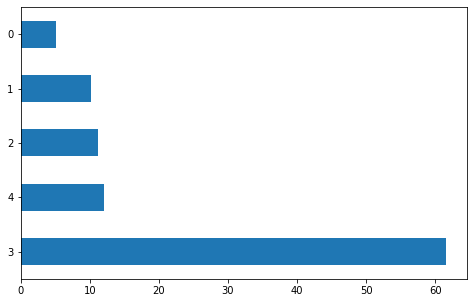

In [19]:
(df.label.value_counts(normalize=True) * 100).plot.barh(figsize = (8, 5))

In [20]:
df['filename'] = df['image_id'].map(lambda x : dataset_path + '/train_images/' + x)
df = df.drop(columns = ['image_id'])
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
df.head()

label                                           filename
0     4  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
1     1  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
2     3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
3     3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...
4     3  /content/gdrive/MyDrive/1_AUSTIN CHEN/Data Sci...

Check how many images are available in the training dataset and also check if each item in the training set are unique

In [35]:
with open(dataset_path + '/label_num_to_disease_map.json') as file:
  id2label = json.loads(file.read())
id2label

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In this case, we have 5 labels (4 diseases and healthy):

1. Cassava Bacterial Blight (CBB)
2. Cassava Brown Streak Disease (CBSD)
3. Cassava Green Mottle (CGM)
4. Cassava Mosaic Disease (CMD)
5. Healthy

In this case label 3, [Cassava Mosaic Disease (CMD)](https://en.wikipedia.org/wiki/Cassava_mosaic_virus) is the most common label. This imbalance may have to be addressed with a weighted loss function or oversampling. I might try this in a future iteration of this kernel or in a new kernel.

Let's check an example image to see what it looks like

In [37]:
from PIL import Image
img = Image.open(df[df.label==3]['filename'].iloc[0])

In [33]:
#hide-input
width, height = img.size
print(f"Width: {width}, Height: {height}")

Width: 800, Height: 600


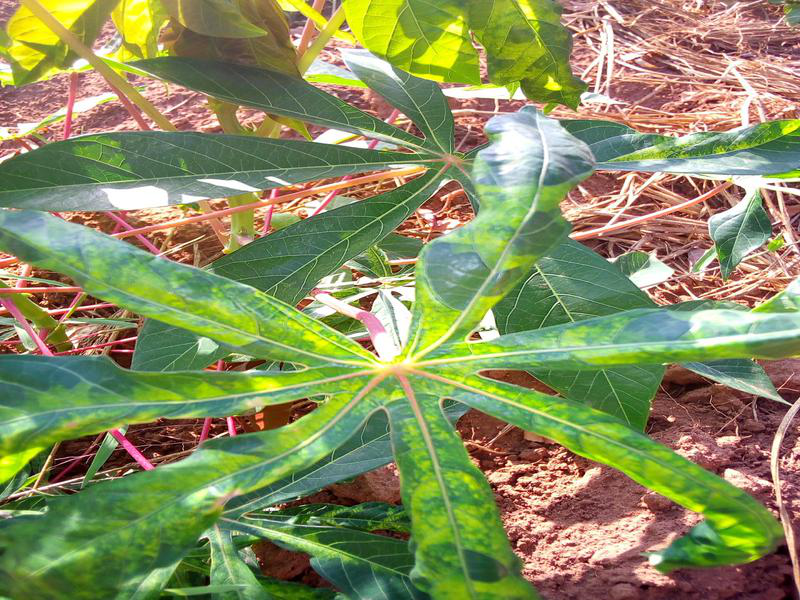

In [25]:
#hide-input
img

# Config parameters

In [28]:
SELECT = ("efficientnet_b3", 300) #param ["(\"efficientnet_b4\", 380)", "(\"efficientnet_b2\", 260)"] {type:"raw", allow-input: true}
BASE_MODEL, SIZE = SELECT
BASE_MODEL_URL = "https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(BASE_MODEL)
BATCH_SIZE = 32 #param {type:"integer"}
IMG_SIZE = (SIZE, SIZE)
print("Using {} with input size {}".format(BASE_MODEL, SIZE))

Using efficientnet_b3 with input size 300


# Load data

After my quick and rough EDA, let's load the PIL Image to a Numpy array, so we can move on to data augmentation.

In fastai, they have `item_tfms` and `batch_tfms` defined for their data loader API. The item transforms performs a fairly large crop to 224 and also apply other standard augmentations (in aug_tranforms) at the batch level on the GPU. The batch size is set to 32 here.

## Split Dataset


> Important: Since we are using built-in generator, it takes label as string

In [40]:
df['label'] = df['label'].astype('str')

In [42]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    df
    ,test_size = 0.2
    ,random_state=SEED
    ,shuffle = True
    ,stratify = df['label']
    )

In [58]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df.filename.values,train_df.label.values))
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid_df.filename.values, valid_df.label.values))

In [61]:
for x,y in valid_ds.take(3):
  print(x, y)

tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/1058931181.jpg', shape=(), dtype=string) tf.Tensor(b'3', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/3541075880.jpg', shape=(), dtype=string) tf.Tensor(b'3', shape=(), dtype=string)
tf.Tensor(b'/content/gdrive/MyDrive/1_AUSTIN CHEN/Data Scientist/Datasets/cassava-leaf-disease-classification/train_images/1362873947.jpg', shape=(), dtype=string) tf.Tensor(b'4', shape=(), dtype=string)


## Data generator

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [66]:
def process_train(filename, label):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.random_brightness(img, 0.3)
  img = tf.image.random_flip_left_right(img, seed=None)
  img = tf.image.random_crop(img, size=[*IMG_SIZE, 3])
  return img, label

def process_valid(filename, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [*IMG_SIZE, 3])
  return img, labe

In [68]:
train_ds = train_ds.map(process_train, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_valid, num_parallel_calls=AUTOTUNE)

TypeError: ignored

## Use `tf.Data`
In this section, I will learn to use `tf.data`, the set of API enables you to build complex input pipelines from simple, reusable pieces. 

> Important: Removing normalizaiton step in generator since in EfficientNet, normalization is done within the model itself and the model expects input in the range of [0,255]

In [ ]:
datagen_kwargs = dict(
   ,horizontal_flip     = True
   ,vertical_flip       = True
   ,height_shift_range  = 0.2
   ,width_shift_range   = 0.2
   ,brightness_range    = [0.7, 1.5]
   ,rotation_range      = 30
   ,shear_range         = 0.2
   ,fill_mode           = 'nearest'
   ,zoom_range          = [0.3,0.6]
)

dataflow_kwargs = dict(
   x_col       = 'filename'
   ,y_col       = 'label'
   ,class_mode  = "categorical"
   ,target_size = IMG_SIZE
   ,color_mode  = 'rgb'
   ,batch_size  = BATCH_SIZE
)

In [ ]:
dgnr_train = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
ditr_train = dgnr_train.flow_from_dataframe(df_train, shuffle=True, **dataflow_kwargs)

Found 17117 validated image filenames belonging to 5 classes.


> Note: I was shuffing the validation set which is a bug

In [ ]:
dgnr_valid = tf.keras.preprocessing.image.ImageDataGenerator()
ditr_valid = dgnr_valid.flow_from_dataframe(df_valid, shuffle=False, **dataflow_kwargs)

Found 4280 validated image filenames belonging to 5 classes.


In [ ]:
def show_images(di):
  xs, ys = next(di)
  _,axs = plt.subplots(4,6,figsize=(24,16))
  for (x, y, ax) in zip(xs, ys, axs.flatten()):
    ax.imshow(x.astype(np.uint8))
    ax.set_title(np.argmax(y))
    ax.axis('off')

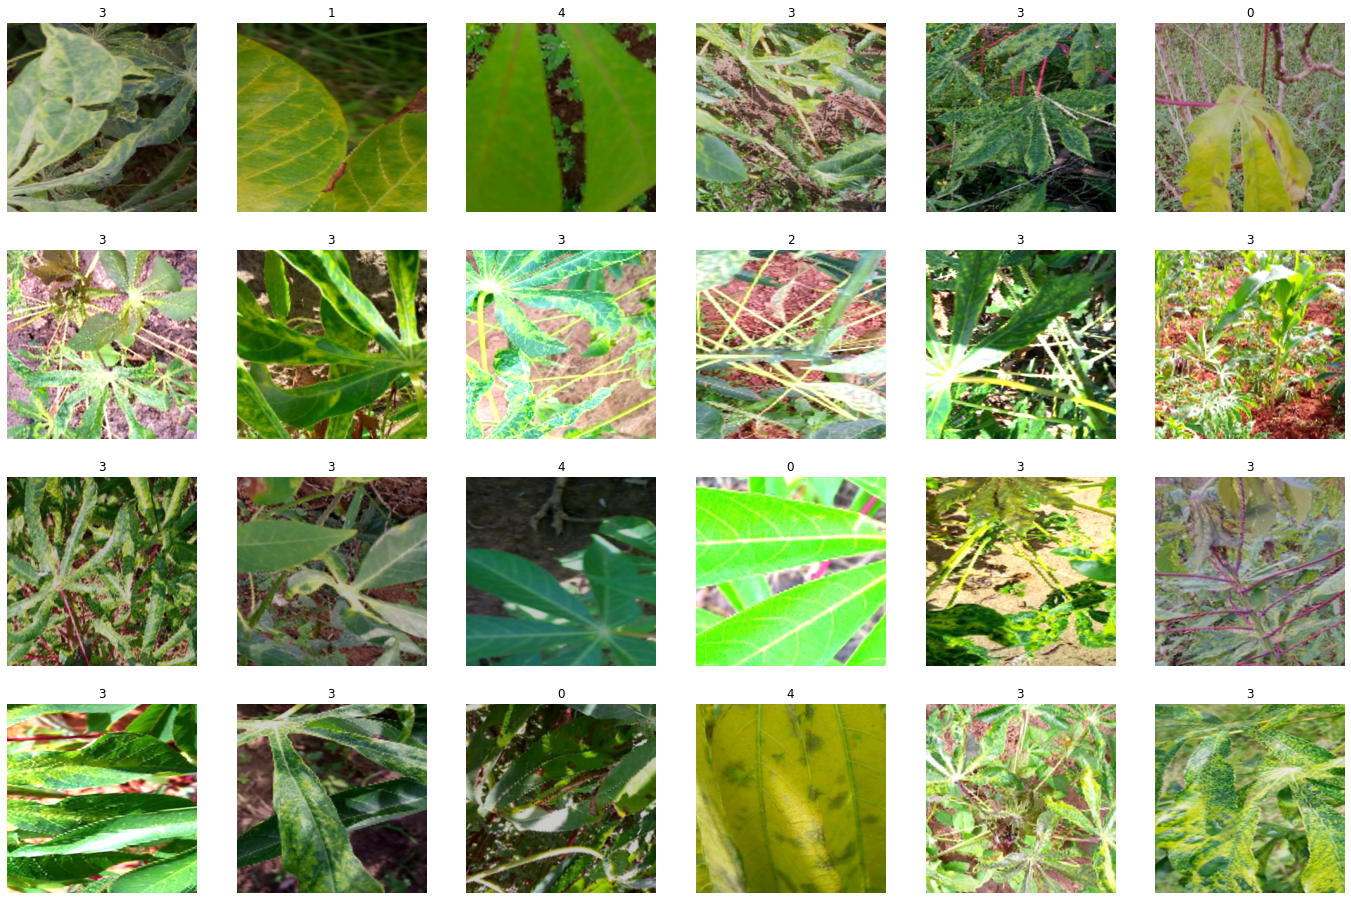

In [ ]:
show_images(ditr_train)

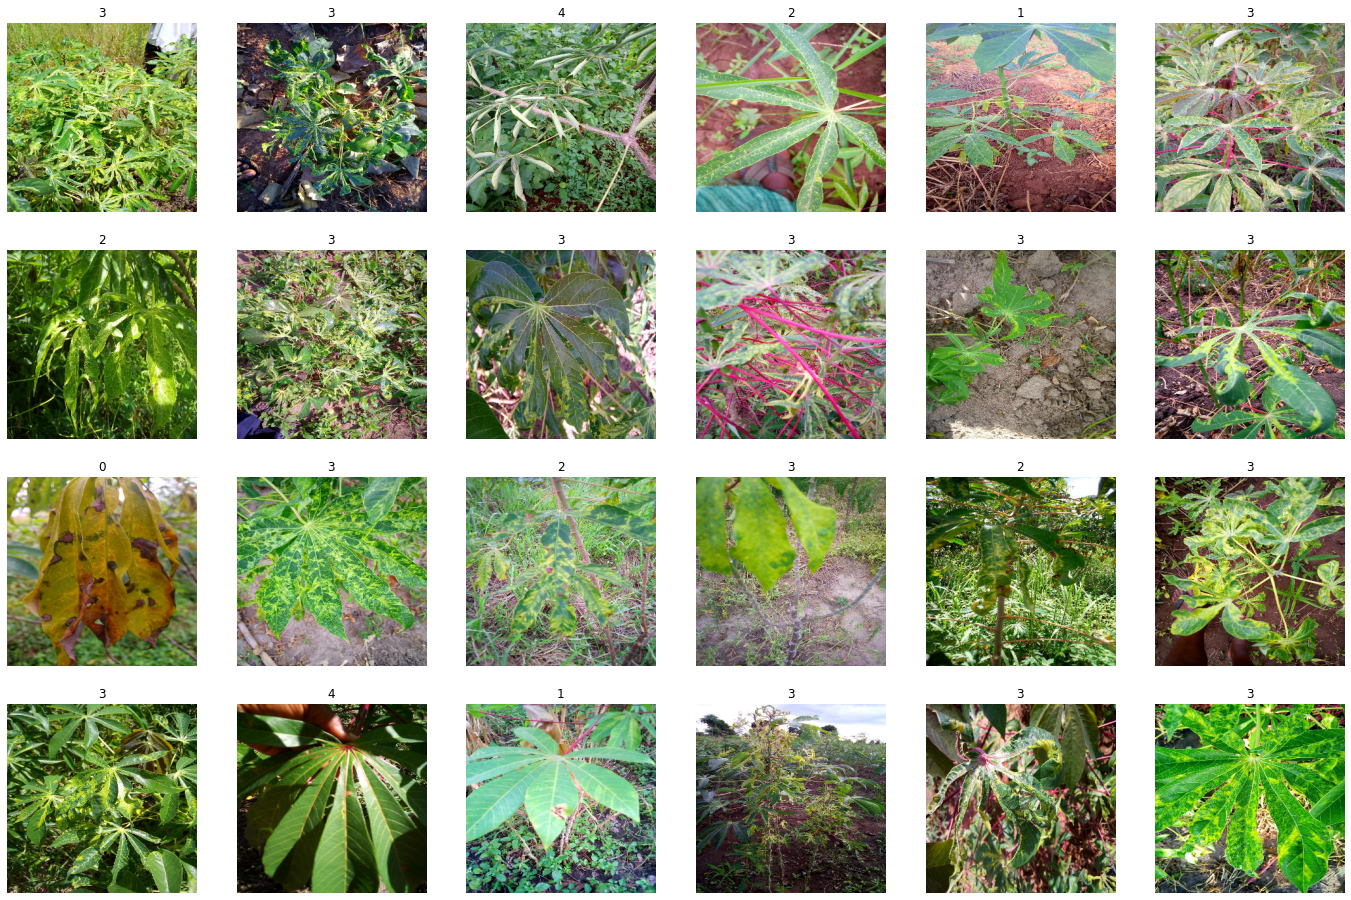

In [ ]:
show_images(ditr_valid)

# Create model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.losses import CategoricalCrossentropy

In [29]:
#hide
!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5

--2020-12-15 22:44:01--  https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43941136 (42M) [application/x-hdf]
Saving to: ‘efficientnetb3_notop.h5.1’

efficientnetb3_noto 100%[===================>]  41.91M  24.6MB/s    in 1.7s    

2020-12-15 22:44:03 (24.6 MB/s) - ‘efficientnetb3_notop.h5.1’ saved [43941136/43941136]



In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

In [ ]:
base_model = EfficientNetB3(
    weights=dataset_path + "/efficientnetb3_notop.h5", 
    include_top=False, 
    input_shape=(*IMG_SIZE, 3), 
    drop_connect_rate=0.4)

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               393472    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [ ]:
model.build([None, expect_img_size, expect_img_size, 3])  # Batch input shape.

In [ ]:
def build_my_model(base_model, optimizer, loss='categorical_crossentropy', metrics = ['categorical_accuracy']):
    
    my_model = Sequential()    
    my_model.add(base_model)
    my_model.add(GlobalAveragePooling2D())
    my_model.add(Dense(256))
    my_model.add(BatchNormalization())
    my_model.add(Activation('relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(5, activation='softmax'))
    my_model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(label_smoothing=0.05),
        metrics=metrics
    )
    return my_model

In [ ]:
def load_pretrained_model(weights_path, drop_connect,
                          target_size_dim, layers_to_unfreeze=5):
    model = EfficientNetB3(
            weights=None, 
            include_top=False, 
            input_shape=(target_size_dim, target_size_dim, 3),
            drop_connect_rate=0.4
        )
    
    model.load_weights(weights_path)
    
    model.trainable = True

    # for layer in model.layers[-layers_to_unfreeze:]:
    #     if not isinstance(layer, tf.keras.layers.BatchNormalization): 
    #         layer.trainable = True

    if DEBUG:
        for layer in model.layers:
            print(layer.name, layer.trainable)

    return model

# 1% Better Everyday

https://www.kaggle.com/frlemarchand/efficientnet-aug-tf-keras-for-cassava-diseases
https://www.kaggle.com/harveenchadha/efficientnetb3-keras-tf2-baseline-training

**todos**
- Find out the intuition and the difference between `item_tfm` and `batch_tfm`
- Customize my own data generator as fastai creates their `Dataloader`
- Prepare a special dataset that will be fed to the Normalization layer. The `EfficientnetB3` provided by `tf.keras` includes an out-of-the-box Normalization layer fit onto the `imagenet` dataset. Therefore, we can pull that layer and use the `adapt` function to retrain it to the Cassava Disease dataset.
- The 3rd layer of the Efficientnet is the Normalization layer, which can be tuned to our new dataset instead of `imagenet`. Be patient on this one, it does take a bit of time we're going through the entire training set.

---

**done**
- Try out the `data_generator` and the `data_frame_iterator`
- Removing normalizaiton step in generator since in EfficientNet, normalization is done within the model itself and the model expects input in the range of [0,255]


# Augmentation

The `albumentation` is primarily used for resizing and normalization.

In [ ]:
# For Training 
def albu_transforms_train(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
            A.ToFloat(),
            A.Resize(data_resize, data_resize),
        ], p=1.)

In [ ]:
def CutMix(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    
    return image2,label2

In [ ]:
def MixUp(image, label, DIM, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    CLASSES = 5
    
    imgs = []; labs = []
    for j in range(len(image)):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
                   
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,len(image)),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
                    
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
                    
        # MAKE CUTMIX LABEL
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(len(image),DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(len(image),CLASSES))
    return image2,label2